# Prepare data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
import numpy as np
import random

In [2]:
## Hyper-parameters
RATIO = 0.8   ## What ratio of total lines used for training (the rest is for validation)
FC_SIZE = 100
LR = 1e-3
EPOCH = 3
BATCH_SIZE = 100
KERNEL_SIZE = 5     ## One side (square)
FEATURE_MAP1 = 3   ## First conv layer feature maps
FEATURE_MAP2 = 6   ## Second conv layer feature maps

In [3]:
with open("../data/train.csv") as f:
    lines_all = [line for line in f]

In [4]:
lines = [np.array(line.split(","), dtype='float32') for line in lines_all[1:]]
random.shuffle(lines)

In [5]:
training_images = []
training_labels = []
training_set = []
validation_images = []
validation_labels = []
validation_set = []
for line in lines[:int(len(lines) * RATIO)]:
    one_hot = np.zeros((10), dtype='float32')
    one_hot[int(line[0])] = 1.0
    training_labels.append(one_hot)
    training_images.append(np.array(line[1:], dtype='float32'))
    training_set.append((one_hot, line[1:]))
for line in lines[int(len(lines) * RATIO):]:
	one_hot = np.zeros((10), dtype='float32')
	one_hot[int(line[0])] = 1.0
	validation_labels.append(one_hot)
	validation_images.append(np.array(line[1:], dtype='float32'))
	validation_set.append((one_hot, line[1:]))

In [6]:
## Constants
TRAINING_SIZE = int(len(lines) * RATIO)
VALIDATION_SIZE = len(lines) - TRAINING_SIZE
TRAINING_BATCH = TRAINING_SIZE / BATCH_SIZE
VALIDATION_BATCH = VALIDATION_SIZE / BATCH_SIZE

In [7]:
print TRAINING_SIZE, VALIDATION_SIZE

33600 8400


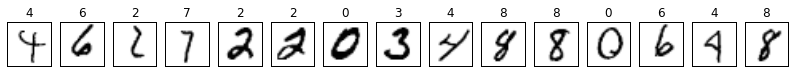

In [8]:
## See random n digit with their labels
n = 15
random.shuffle(training_set)
fig = plt.figure()
for i, digit in enumerate(training_set[:n]):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(digit[0].nonzero()[0][0])  ## Label
    plt.imshow(digit[1].reshape((28, 28)), cmap=plt.cm.Greys)

# Preparing network

In [9]:
import tensorflow as tf
import time

In [10]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [11]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [12]:
## Input, output vectors
x = tf.placeholder(tf.float32, [None, 784])  ## Here 'None' means that a dimension can be of any length
y_ = tf.placeholder(tf.float32, [None, 10])  ## Correct answers

In [13]:
## 1st conv layer
## [Kernel size1, Kernel size2, first layer channel, second layer channel channel]
W_conv1 = weight_variable([KERNEL_SIZE, KERNEL_SIZE, 1, FEATURE_MAP1])
b_conv1 = bias_variable([FEATURE_MAP1])

## [.., shape1, shape2, channel]
x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [14]:
## 2nd conv layer
W_conv2 = weight_variable([KERNEL_SIZE, KERNEL_SIZE, FEATURE_MAP1, FEATURE_MAP2])
b_conv2 = bias_variable([FEATURE_MAP2])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [15]:
## Fully connected layer

## Image shape halves twice. (28x28) -> (14x14) -> (7x7) by max_pool_2x2
## Conv. layer does not change image size because of padding='SAME'
W_fc1 = weight_variable([7 * 7 * FEATURE_MAP2, FC_SIZE])  
b_fc1 = bias_variable([FC_SIZE])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * FEATURE_MAP2])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [16]:
## Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [17]:
## Softmax output
W_fc2 = weight_variable([FC_SIZE, 10])
b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [18]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(LR).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
## Launch the model in a session
sess = tf.Session()
if tf.__version__ == '0.10.0':
	sess.run(tf.initialize_all_variables())   ## tensorflow 0.10
else:
	sess.run(tf.global_variables_initializer())   ## tensorflow 0.12

saver = tf.train.Saver()

In [20]:
##############
## Training ##
##############

#saver.restore(sess, "../model/MLP_tensorflow/MLP_tensorflow.ckpt")
#print("Model restored.")

validation_batches = [validation_set[k:k + BATCH_SIZE] for k in range(0, VALIDATION_SIZE, BATCH_SIZE)]
validation_batch_images = np.array([np.array([digit[1] for digit in batch], dtype='float32') 
                                    for batch in validation_batches], dtype='float32')
validation_batch_labels = np.array([np.array([digit[0] for digit in batch], dtype='float32')
                                    for batch in validation_batches], dtype='float32')

t0 = time.time()
for i in xrange(EPOCH):
	random.shuffle(training_set)
	training_batches = [training_set[k:k + BATCH_SIZE] for k in range(0, TRAINING_SIZE, BATCH_SIZE)]

	training_batch_images = np.array([np.array([digit[1] for digit in batch], dtype='float32')
                                      for batch in training_batches], dtype='float32')
	training_batch_labels = np.array([np.array([digit[0] for digit in batch], dtype='float32')
                                      for batch in training_batches], dtype='float32')

	total_training_accuracy = 0.0
	for j in xrange(TRAINING_BATCH):
		sess.run(train_step, feed_dict={x: training_batch_images[j], y_: training_batch_labels[j], keep_prob: 0.5})
		batch_accuracy = sess.run(accuracy, feed_dict={x: training_batch_images[j], y_: training_batch_labels[j], keep_prob: 1.0})
		total_training_accuracy += batch_accuracy
        
        #classification = sess.run(y_conv, feed_dict={x: training_batch_images[j], keep_prob: 1.0})
        #print classification
        #print training_batch_labels[j]

	################
	## Validating ##
	################


	print "Epoch",  (i + 1), "\n\tTraining accuracy: {0:f}".format(total_training_accuracy / TRAINING_BATCH)

	if RATIO != 1.0:
		total_validation_accuracy = 0.0
		for j in xrange(VALIDATION_BATCH):
			batch_accuracy = sess.run(accuracy, feed_dict={x: validation_batch_images[j], y_: validation_batch_labels[j], keep_prob: 1.0})
			total_validation_accuracy += batch_accuracy

		print "\tValidation accuracy: {0:f}".format(total_validation_accuracy / VALIDATION_BATCH)

print "Total time:", time.time() - t0

#save_path = saver.save(sess, "..model/MLP_tensorflow/MLP_tensorflow.ckpt")
#print("Model saved in file: %s" %save_path)
sess.close()

[[  1.18552584e-20   1.34415610e-27   5.02431241e-22   8.09947420e-33
    6.48251379e-26   4.53895838e-33   1.00000000e+00   0.00000000e+00
    2.84707551e-28   6.83849211e-34]
 [  4.80129651e-37   0.00000000e+00   1.00000000e+00   7.18089707e-22
    0.00000000e+00   6.10966010e-31   0.00000000e+00   3.84593834e-33
    6.36627884e-26   0.00000000e+00]
 [  0.00000000e+00   3.23496068e-34   2.63780345e-25   2.75504376e-34
    1.12800153e-33   7.84371206e-36   0.00000000e+00   1.00000000e+00
    1.99865293e-32   1.48325612e-18]
 [  2.78373567e-27   1.45364616e-26   1.26155435e-32   1.06936074e-25
    2.36408340e-21   1.00000000e+00   2.94519937e-24   1.76202011e-35
    3.64354280e-09   8.99011680e-36]
 [  0.00000000e+00   1.71595830e-35   0.00000000e+00   3.52849733e-37
    2.02601778e-33   1.00000000e+00   3.98612309e-32   2.43369232e-27
    2.73968991e-19   1.03780436e-34]
 [  1.06588332e-24   1.04642362e-25   7.65198612e-23   3.83177475e-27
    1.00000000e+00   1.19766440e-24   1.19752

In [21]:
SystemExit()

SystemExit()

In [22]:
sess.close()

In [23]:
training_batch_images.shape

(336, 100, 784)

In [24]:
training_batch_labels.shape

(336, 100, 10)

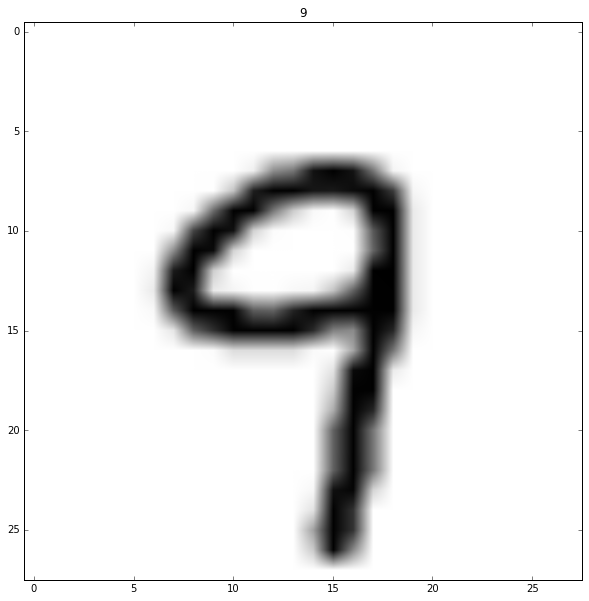

In [25]:
n = 300
b = 54
plt.title(training_batch_labels[n][b].nonzero()[0][0])
plt.imshow(training_batch_images[n][b]. reshape((28,28)), cmap='Greys')

In [26]:
y_conv.eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`